In [1]:
!pip install -q kaggle
# from google.colab import files
# files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d kongaevans/speaker-recognition-dataset
!mkdir speaker-recognition-dataset
!unzip speaker-recognition-dataset.zip -d speaker-recognition-dataset


Streaming output truncated to the last 5000 lines.
  inflating: speaker-recognition-dataset/16000_pcm_speeches/Jens_Stoltenberg/556.wav  
  inflating: speaker-recognition-dataset/16000_pcm_speeches/Jens_Stoltenberg/557.wav  
  inflating: speaker-recognition-dataset/16000_pcm_speeches/Jens_Stoltenberg/558.wav  
  inflating: speaker-recognition-dataset/16000_pcm_speeches/Jens_Stoltenberg/559.wav  
  inflating: speaker-recognition-dataset/16000_pcm_speeches/Jens_Stoltenberg/56.wav  
  inflating: speaker-recognition-dataset/16000_pcm_speeches/Jens_Stoltenberg/560.wav  
  inflating: speaker-recognition-dataset/16000_pcm_speeches/Jens_Stoltenberg/561.wav  
  inflating: speaker-recognition-dataset/16000_pcm_speeches/Jens_Stoltenberg/562.wav  
  inflating: speaker-recognition-dataset/16000_pcm_speeches/Jens_Stoltenberg/563.wav  
  inflating: speaker-recognition-dataset/16000_pcm_speeches/Jens_Stoltenberg/564.wav  
  inflating: speaker-recognition-dataset/16000_pcm_speeches/Jens_Stoltenberg/565

In [2]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import os
import pandas as pd
from scipy import stats

EDA

Average audio length and number of samples in each class.

In [3]:
dir_path = r'/content/speaker-recognition-dataset/16000_pcm_speeches'
result1 = []
print(f'Average audio length in each class : \n')
for x in os.listdir(dir_path):
  sub_dir_path = os.path.join(dir_path,x)
  if os.path.isdir(sub_dir_path):
    count = 0
    durations = []
    for y in os.listdir(sub_dir_path):
      file_path = os.path.join(sub_dir_path,y)
      if os.path.isfile(file_path):
        count += 1
        audio_data, sample_rate = librosa.load(file_path)
        durations.append(librosa.get_duration(y=audio_data,sr=sample_rate))
    result1.append((x,count))
    print(f'{x} : { np.mean(np.array(durations))}')
print(f'\nNo. of samples in each class : \n')
print(result1)

Average audio length in each class : 

Magaret_Tarcher : 1.0
Benjamin_Netanyau : 1.0
_background_noise_ : 58.60929705215419
Nelson_Mandela : 1.0
Julia_Gillard : 1.0
other : 60.626938775510204
Jens_Stoltenberg : 1.0

No. of samples in each class : 

[('Magaret_Tarcher', 1500), ('Benjamin_Netanyau', 1500), ('_background_noise_', 4), ('Nelson_Mandela', 1500), ('Julia_Gillard', 1501), ('other', 2), ('Jens_Stoltenberg', 1500)]


In [4]:
!pip install noisereduce
!pip install pydub

Noise Reduction

In [12]:
import os
from noisereduce import reduce_noise
from pydub import AudioSegment
import numpy as np

directory = "/content/speaker-recognition-dataset/16000_pcm_speeches/"

exclude_directories = ['other', '_background_noise_', 'tf_Wav_reader.py']

speakers_list = [i for i in os.listdir(directory) if i not in exclude_directories]

def apply_noise_reduction(target_audio, noise_folder_path, output_folder_path):
    target_audio_segment = AudioSegment.from_file(target_audio)
    noise_profile = None
    noise_profiles = []

    noise_files = [f for f in os.listdir(noise_folder_path) if f.endswith(".wav")]

    while noise_files:
        noise_file = noise_files.pop()
        noise_audio = AudioSegment.from_file(os.path.join(noise_folder_path, noise_file))
        noise_array = np.array(noise_audio.get_array_of_samples())
        if noise_profile is None:
            noise_profile = np.zeros(len(target_audio_segment))
        if len(noise_array) > len(noise_profile):
            noise_profile = np.pad(noise_profile, (0, len(noise_array) - len(noise_profile)), 'constant')
        elif len(noise_array) < len(noise_profile):
            noise_array = np.pad(noise_array, (0, len(noise_profile) - len(noise_array)), 'constant')
        noise_profile += noise_array
        noise_profiles.append(noise_array)

    if noise_profile is not None:
        noise_profile /= len(noise_profiles)
        target_array = np.array(target_audio_segment.get_array_of_samples())
        reduced_audio = reduce_noise(y=target_array, sr=target_audio_segment.frame_rate, y_noise=noise_profile)
        cleaned_audio = AudioSegment(
            reduced_audio.tobytes(),
            frame_rate=target_audio_segment.frame_rate,
            sample_width=target_audio_segment.sample_width,
            channels=target_audio_segment.channels
        )
        cleaned_audio_path = os.path.join(output_folder_path, os.path.splitext(os.path.basename(target_audio))[0] + ".wav")
        cleaned_audio.export(cleaned_audio_path, format="wav")
    else:
        print("No valid noise files found in the folder.")

for speaker in speakers_list:
    speaker_directory = os.path.join(directory, speaker)
    noise_folder_path = os.path.join(directory, "_background_noise_")
    output_folder_path = os.path.join(directory, speaker + "_cleaned_audio")

    if not os.path.exists(output_folder_path):
        os.makedirs(output_folder_path)

    for file in os.listdir(speaker_directory):
        if file.endswith(".wav"):
            target_audio = os.path.join(speaker_directory, file)
            apply_noise_reduction(target_audio, noise_folder_path, output_folder_path)

Pre_emphasis

In [3]:
import os
import librosa

directory = '/content/speaker-recognition-dataset/16000_pcm_speeches'
pre_emphasis_coefficient = 0.97
preem_speaker_name = {}
exclude_directories = ['other', 'background_noise', 'tf_Wav_reader.py']
speakers_list = [i for i in os.listdir(directory) if i not in exclude_directories]

for speaker_name in speakers_list:
    speaker_directory = os.path.join(directory, speaker_name)
    preem_audio_list = []

    for filename in os.listdir(speaker_directory):
        if filename.endswith(".wav"):
            audio_file = os.path.join(speaker_directory, filename)
            audio, sample_rate = librosa.load(audio_file, sr=None)
            pre_emphasized_audio = librosa.effects.preemphasis(audio, coef=pre_emphasis_coefficient)
            preem_audio_list.append([filename, pre_emphasized_audio])

    preem_speaker_name[speaker_name] = preem_audio_list


Plotting Spectrogram

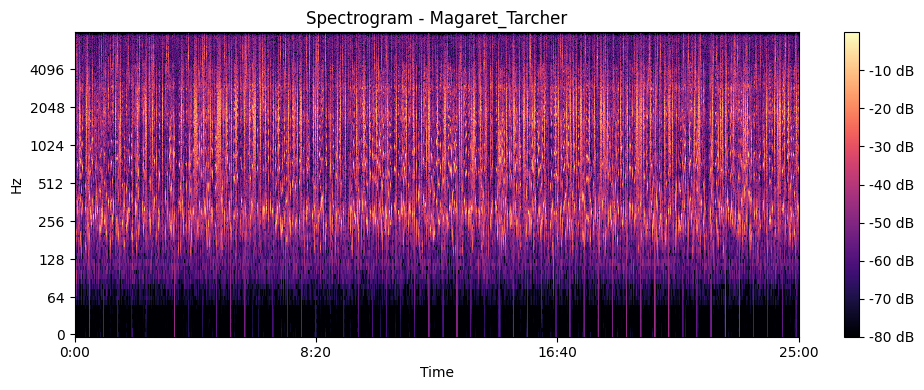

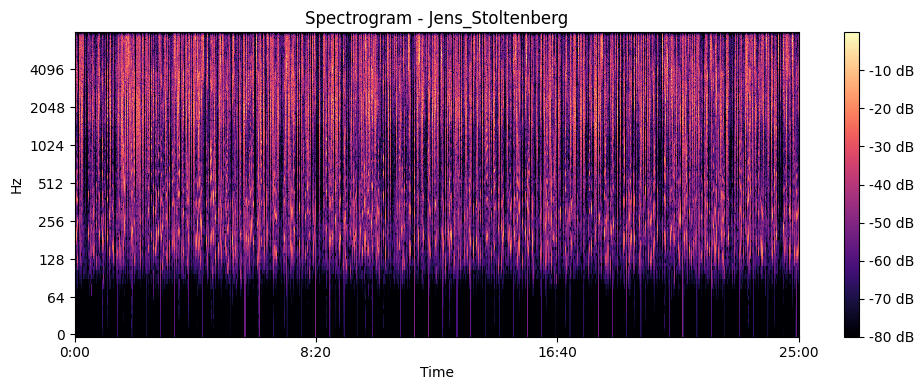

In [14]:
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

n_fft = 2048
hop_length = 512
sr = 16000

for speaker, audio_list in preem_speaker_name.items():
    if(speaker=='Magaret_Tarcher' or speaker=='Jens_Stoltenberg'):
      combined_audio = np.concatenate(audio_list, axis=-1)
      D = librosa.amplitude_to_db(np.abs(librosa.stft(combined_audio, n_fft=n_fft, hop_length=hop_length)), ref=np.max)
      plt.figure(figsize=(10, 4))
      librosa.display.specshow(D, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
      plt.colorbar(format='%+2.0f dB')
      plt.title(f'Spectrogram - {speaker}')
      plt.tight_layout()
      plt.show()


Calculating Threshold for each speaker

In [7]:
import librosa
import statistics

FRAME_SIZE = 1024
HOP_LENGTH = 512
median_rms_per_speaker = {}

for speaker_name, audio_list1 in preem_speaker_name.items():
    all_rms_speech = []
    audio_list = [x[1] for x in audio_list1]

    for audio in audio_list:
        rms_speech = librosa.feature.rms(y=audio, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
        mean_rms = rms_speech.mean()
        all_rms_speech.append(mean_rms)

    median_rms = statistics.median(all_rms_speech)
    median_rms_per_speaker[speaker_name] = median_rms

print(median_rms_per_speaker)


{'Magaret_Tarcher': 0.054054975509643555, 'Benjamin_Netanyau': 0.052269816398620605, '_background_noise_': 0.010414425283670425, 'Nelson_Mandela': 0.12113793939352036, 'Julia_Gillard': 0.11723718, 'Jens_Stoltenberg': 0.04348672926425934}


In [8]:
count = 0
threshold = 0.052
noise_benj=[]
for x in preem_speaker_name['Benjamin_Netanyau']:

        rms_speech = librosa.feature.rms(y=x[1], frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
        if np.median(rms_speech) >= threshold:
          noise_benj.append(x[0])
          count += 1
print(count)

697


In [9]:
count = 0
threshold = 0.01211
noise_benj=[]
for x in preem_speaker_name['Nelson_Mandela']:

        rms_speech = librosa.feature.rms(y=x[1], frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
        if np.median(rms_speech) >= threshold:
          noise_benj.append(x[0])
          count += 1
print(count)

1500


In [10]:
count = 0
threshold = 0.0540
noise_benj=[]
for x in preem_speaker_name['Magaret_Tarcher']:

        rms_speech = librosa.feature.rms(y=x[1], frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
        if np.median(rms_speech) >= threshold:
          noise_benj.append(x[0])
          count += 1
print(count)

695


In [11]:
count = 0
threshold = 0.0434
noise_benj=[]
for x in preem_speaker_name['Jens_Stoltenberg']:

        rms_speech = librosa.feature.rms(y=x[1], frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
        if np.median(rms_speech) >= threshold:
          noise_benj.append(x[0])
          count += 1
print(count)

553


In [12]:
count = 0
threshold = 0.1172
noise_benj=[]
for x in preem_speaker_name['Julia_Gillard']:

        rms_speech = librosa.feature.rms(y=x[1], frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]
        if np.median(rms_speech) >= threshold:
          noise_benj.append(x[0])
          count += 1
print(count)

442


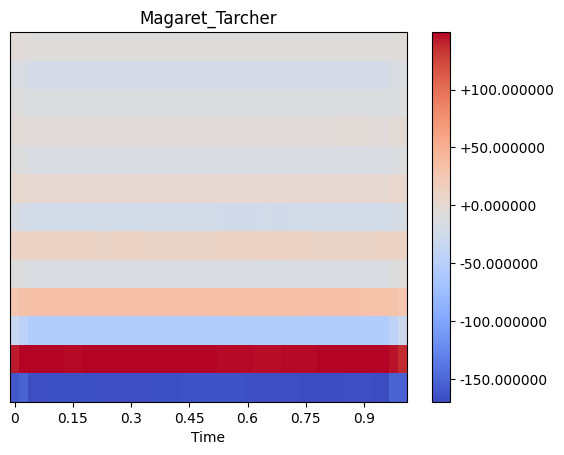

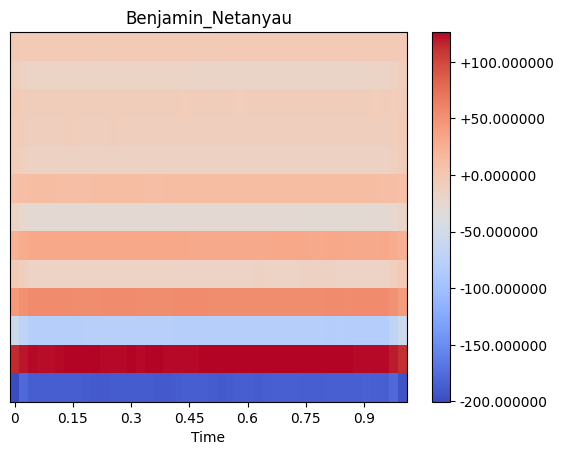

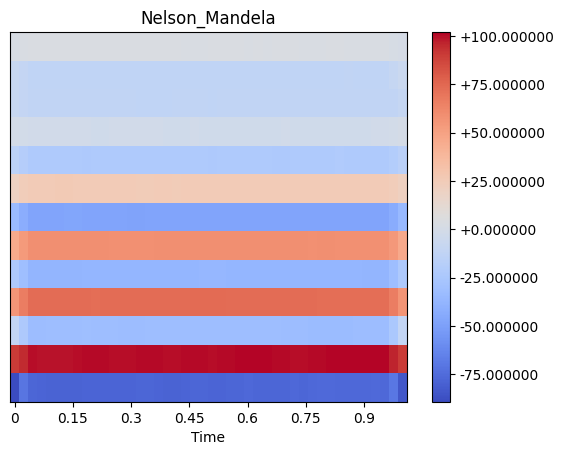

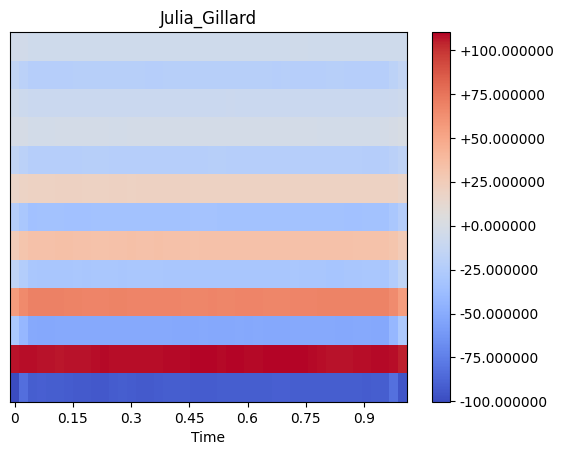

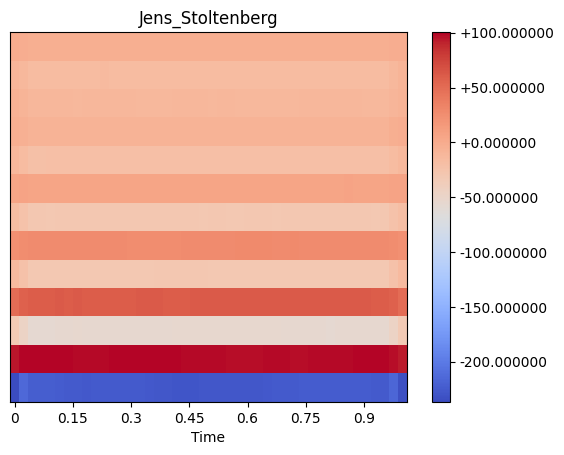

{0: 'Magaret_Tarcher', 1: 'Benjamin_Netanyau', 2: 'Nelson_Mandela', 3: 'Julia_Gillard', 4: 'Jens_Stoltenberg'}


In [15]:
dir_path = r'/content/speaker-recognition-dataset/16000_pcm_speeches'
label = {}
label_count = 0
for x in os.listdir(dir_path):
  if x in ['other','_background_noise_','tf_Wav_reader.py']:
    continue
  label[label_count] = x
  sub_dir_path = os.path.join(dir_path,x)
  if os.path.isdir(sub_dir_path):
    count = 0
    speaker_data = np.zeros((13,44))
    for y in os.listdir(sub_dir_path):
      file_path = os.path.join(sub_dir_path,y)
      if os.path.isfile(file_path):
        audio_data, sample_rate = librosa.load(file_path)
        mfccs = librosa.feature.mfcc(y=audio_data,n_mfcc=13,sr=sample_rate)
        speaker_data = speaker_data + mfccs
        #delta_mfccs = librosa.feature.delta(mfccs)
        #delta2_mfccs = librosa.feature.delta(mfccs,order=2)
        count += 1
    label_count += 1
    speaker_data = speaker_data/1500
    plt.figure()
    librosa.display.specshow(speaker_data,x_axis='time',sr=sample_rate)
    plt.colorbar(format="%+2f")
    plt.title(x)
    plt.show()
print(label)